# Plotting results

In [1]:
from echopop.survey import Survey
init_config = "C:/Users/Brandyn/Documents/GitHub/echopop/config_files/initialization_config.yml"
file_config = "C:/Users/Brandyn/Documents/GitHub/echopop/config_files/survey_year_2019_config.yml"
survey = Survey(init_config, file_config)
survey.load_survey_data(verbose=False)
survey.load_acoustic_data(verbose=False)
survey.transect_analysis(verbose=False)
survey.fit_variogram(verbose=False)
survey.kriging_analysis(variogram_parameters={"n_lags": 30}, 
                        variable="biomass_density", verbose=False)

The primary plotting method for the `Survey`-class object is `Survey.plot`, which comprises four primary arguments: 
- `kind` (`str`): The 'kind' of plot and dataset that will be visualized.
- `variable` (`str`): The variable used for plotting.
- `plot_parameters` (`Dict[str, Any]`): A dictionary comprising various plotting keyword arguments.
- `plot_type` (`str`): The type of plot used to visualize the defined dataset. 

Many of these parameter inputs depend on the input for `kind`. This can be determined with the following table:

<table style="width:100%; table-layout:fixed; border: 2px solid lightgray; border-collapse: collapse;">
   <thead>
      <tr>
         <th style="width: 20%; word-wrap: break-word; border: 1.5px solid lightgray;">
         <b><code>kind</code></b>
         </th>
         <th style="width: 25%; word-wrap: break-word; border: 1.5px solid lightgray;">
         <b><code>variable</code></b>
         </th>
         <th style="width: 30%; word-wrap: break-word; border: 1.5px solid lightgray;">
         <b><code>plot_parameters</code></b>
         </th>
         <th style="width: 20%; word-wrap: break-word; border: 1.5px solid lightgray;">
         <b><code>plot_type</code></b>
         </th>
      </tr>
   </thead>
   <tbody>
      <tr>
         <td style="word-wrap: break-word; border: 1px solid lightgray;"> 
         <code>"age_length_distribution"</code> <br>
         Two-dimensional heatmap of population estimates as a function of age and length
         </td>
         <td style="word-wrap: break-word; border: 1px solid lightgray;">
         - <code>"abundance"</code>: Animal abundance <br> 
         - <code>"biomass"</code>: Animal biomass   
         </td>
         <td style="word-wrap: break-word; border: 1px solid lightgray;">
         - <code>colorbar_label</code>: Label for the plot colorbar <br>
         - <code>grid_heatmap</code>: A boolean argument for applying correctly spaced gridlines to the heatmap <br> 
         - <code>log_base</code>: When defined, it sets the base of the log-transform for renormalizing the colorbar  
         - <code>sex</code>: Animal sex that will be plotted             
         </td>
         <td style="word-wrap: break-word; border: 1px solid lightgray;">
         - <code>"heatmap"</code>: Two-dimensional heatmap      
         </td>
      </tr>
      <tr>
         <td style="word-break: keep-all; border: 1px solid lightgray;">         
         <code>"mesh"</code> <br>
         Kriged population estimates distributed across a mesh grid   
         </td>
         <td>
         - <code>"biomass"</code>: Kriged animal biomass <br>
         - <code>"biomass_density"</code>: Kriged animal biomass density <br>
         - <code>"kriged_cv"</code>: Kriging mesh node coefficient of variation (<i>CV</i>) <br>
         - <code>"kriged_variance"</code>: Variance and uncertainty in kriged prediction <br>
         - <code>"local_variance"</code>: Local variance of transect values around each mesh node <br>         
         </td> 
         <td style="overflow-wrap: break-word; word-break: normal; border: 1px solid lightgray;">
         - <code>colorbar_label</code> <br>
         - <code>geo_config</code>: A dictionary containing geospatial keyword arguments including the initial geospatial projection (<code>"init"</code>), a projection used for plotting (<code>"plot_projection"</code>), and a land/coastline <code>cartopy.feature.Feature</code> object (<code>"coastline</code>) <br>
         - <code>log_base</code>
         </td>
         <td style="word-break: keep-all; border: 1px solid lightgray;">
         - <code>"hexbin"</code>: Hexagonal binned plot <br>
         - <code>"pcolormesh"</code>: Interpolated pseudocolor mesh/raster <br>
         - <code>"scatter"</code>: Scatter/bubble plot
         </td>
      </tr>
      <tr>
         <td style="word-break: keep-all; border: 1px solid lightgray;">
         <code>"transect"</code> <br>
         Bubbleplot of various along-transect population estimates
         </td>
         <td style="word-break: keep-all; border: 1px solid lightgray;">
         - <code>"abundance"</code> <br> 
         - <code>"abundance_female"</code>: Female abundance <br> 
         - <code>"abundance_male"</code>: Male abundance <br> 
         - <code>"biomass"</code> <br>    
         - <code>"biomass_female"</code>: Female biomass <br> 
         - <code>"biomass_male"</code>: Male biomass <br>    
         - <code>"biomass_density"</code>: Areal animal biomass density <br> 
         - <code>"biomass_density_female"</code>: Areal female biomass density <br> 
         - <code>"biomass_density_male"</code>: Areal male biomass density <br> 
         - <code>"nasc"</code>: Vertically integrated acoustic backscatter (nautical area scattering
            coefficient, <i>NASC</i>) <br>
         - <code>"number_density"</code>: Areal animal number density <br>
         - <code>"number_density_female"</code>: Areal female number density <br>
         - <code>"number_density_male"</code>: Areal male number density <br>
         </td>
         <td style="word-break: keep-all; border: 1px solid lightgray;">
         - <code>colorbar_label</code> <br>
         - <code>geo_config</code> <br>
         - <code>log_base</code>
         </td>
         <td style="word-break: keep-all; border: 1px solid lightgray;">
         - <code>"scatter"</code>
         </td>
      </tr>
   </tbody>
</table>

In addition to these plot-specific parameterizations, additional `matplotlib.pyplot.plot` keyword arguments (`kwargs`) can also be supplied within the `plot_parameters`. The primary ones used within `Survey.plot` include:
- `cmap`: Plot colormap.
- `vmax`: Maximum data value
- `vmin`: Minimum data value

## Joint length-age population distributions

Distributions of abundance and biomass along length and age for each sex can be visualized via `kind="age_length_distribution"`. Without additional arguments supplied to `plot_parameters`, default values are applied. So let us first plot the 2D abundance distribution for all fish (note that `sex="all"` is the default argument value within `plot_parameters`).

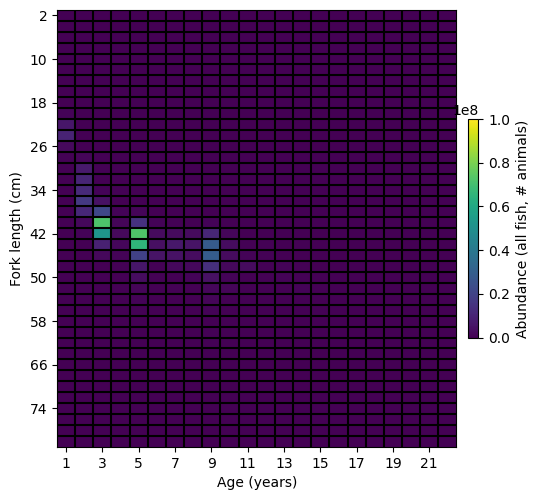

In [2]:
survey.plot(kind="age_length_distribution", 
            variable="abundance")

Due to data range, the distribution is obscured by a handful of very large values. This can be rescaled via log-transforming the colormap to help normalize how the data are distributed across the colormap.

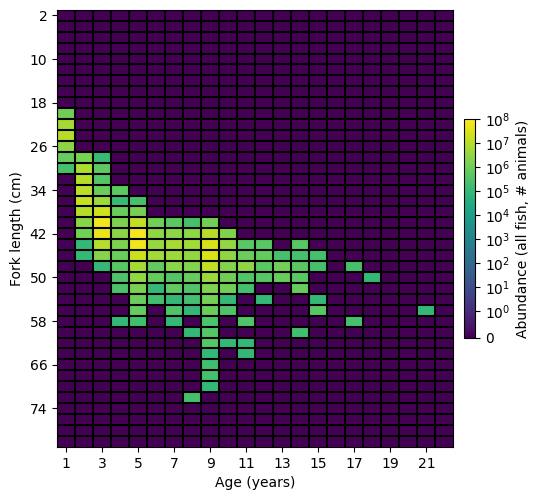

In [3]:
survey.plot(kind="age_length_distribution", 
            variable="abundance", 
            plot_parameters={"log_base": 10})

Instead of looking at `sex="all"`, let us look at the distribution of biomass for just female fish and manually define a few other parameters.

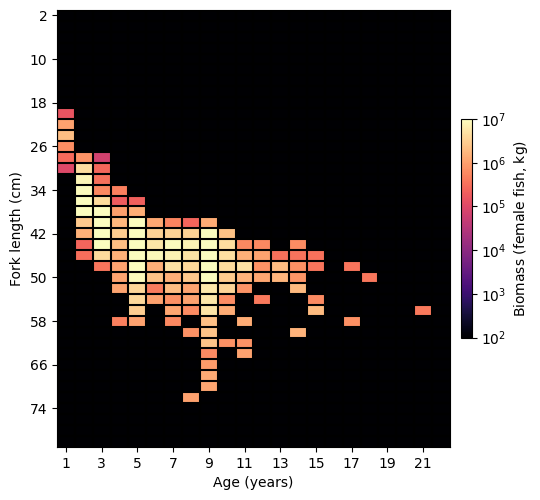

In [4]:
survey.plot(kind="age_length_distribution", 
            variable="biomass", 
            plot_parameters={"log_base": 10,
                             "sex": "female",
                             "cmap": "magma",
                             "vmin": 1e2,
                             "vmax": 1e7})

Compare this to the figure for just male fish biomass:

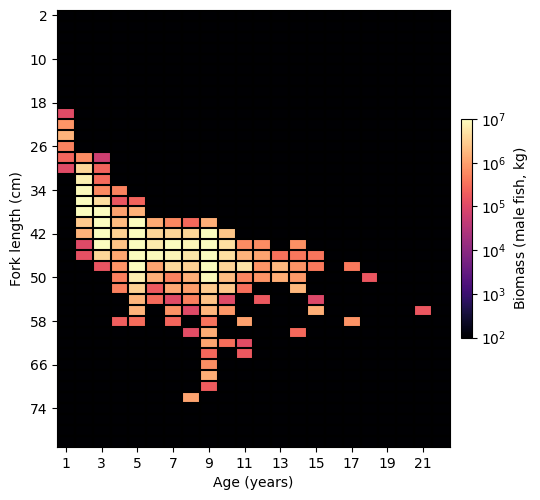

In [5]:
survey.plot(kind="age_length_distribution", 
            variable="biomass", 
            plot_parameters={"log_base": 10,
                             "sex": "male",
                             "cmap": "magma",
                             "vmin": 1e2,
                             "vmax": 1e7})

```{note}
The ability to define specific columns, tables, and custom calculations (e.g. sex ratio) is planned for future updates.
```

## Along-transect spatial distributions

Spatial distributions of population estimate can also be visualized via `kind="transect"`, where the fill and radius of individual points scale to the relative magnitudes for the defined `variable`. When looking at just `variable="nasc"`:

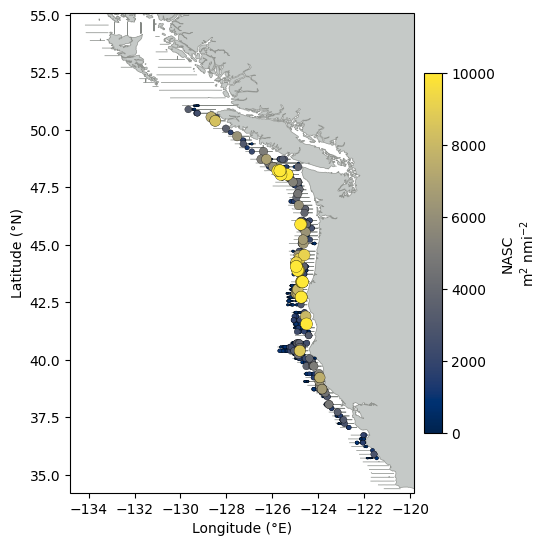

In [6]:
survey.plot(kind="transect", variable="nasc")

This spatial plot also has an additional argument that can be supplied to `plot_parameters`: `geo_config`. When this is not defined, default projection values from the `Survey` object configuration are used for `init`. This can be checked via:

In [7]:
survey.config["geospatial"]

{'init': 'epsg:4326'}

However, additional information can be supplied to `geo_config`, including the arguments `plot_projection` and `coastline`. The `plot_projection` argument defines which projection is used to generate the actual plot, which defaults to `cartopy.crs.PlateCarree()`. Additionally, the argument `coastline` can be defined using any valid `cartopy.feature.Feature` object, which defaults to `cartopy.feature.NaturalEarthFeature(...)`. When all of this is combined, the `geo_config` can be manually set up by the user via:

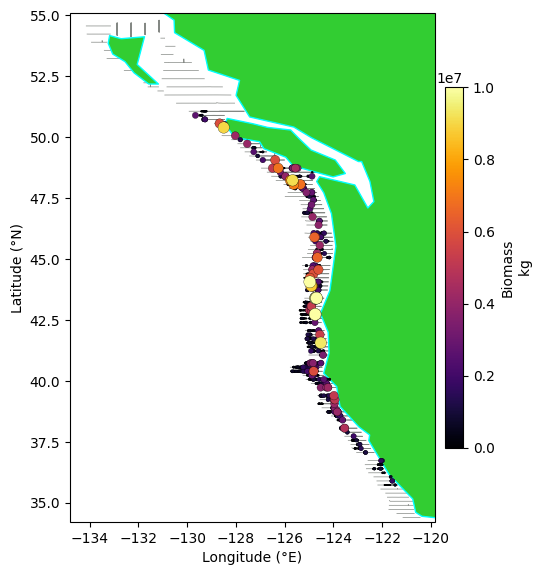

In [8]:
from cartopy.crs import PlateCarree
from cartopy.feature import NaturalEarthFeature

# Define the initial projection
init = "epsg:4326"

# Define the plot projection
plot_projection = PlateCarree()

# Define the coastline shape object (whatever floats your boat doesn't sink mine...)
eyesore_coastline = NaturalEarthFeature(
    category="physical",
    name="coastline",
    scale="110m",
    linewidth=1.0,
    facecolor="limegreen",
    edgecolor="cyan",
)

# Create dictionary
plot_geo_config = dict(init=init, plot_projection=plot_projection, coastline=eyesore_coastline)

# Plot
survey.plot(kind="transect", 
            variable="biomass",
            plot_parameters={
                "geo_config": plot_geo_config
            })

## Interpolated (kriged) spatial distributions

Similar to `kind="transect"`, the kriged population estimates can also be visualized spatially. Unlike the transect data which display the along-transect estimates, `kind="mesh"` shows population estimates spatially distributed across the kriged interpolation mesh supplied by the `Survey` object.

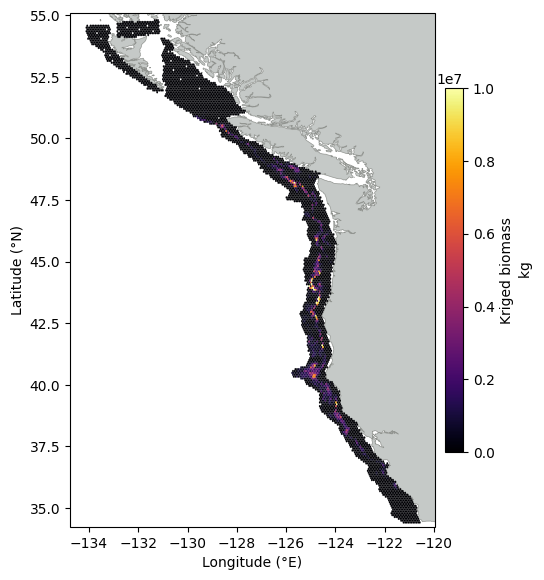

In [9]:
survey.plot(kind="mesh", variable="biomass")

The default plot uses `plot_type="hexbin"`, which either sums or averages values across defined *x*- and *y*-axis resolutions (*see argument details for `matplotlib.plot.hexbin` for more details*). For instance, the `reduce_C_function` argument from `matplotlib.plot.hexbin` can be added to `plot_parameters` to adjust the operation for aggregating data within each hexagonal bin. The default `reduce_C_function` for `variable="biomass"` is `numpy.sum`. Otherwise, `numpy.mean` is used as the default function. For instance, the standard deviation (`numpy.std`) for hexagonally binned biomass density can be displayed instead of the default mean values:

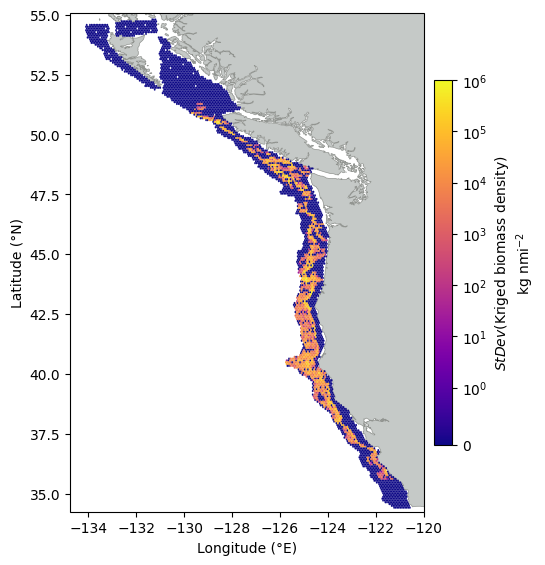

In [10]:
import numpy as np

survey.plot(kind="mesh", 
            variable="biomass_density", 
            plot_type="hexbin", 
            plot_parameters={
                "reduce_C_function": np.std, 
                "colorbar_label": "$StDev$(Kriged biomass density)\nkg nmi$^{-2}$",
                "log_base": 10})

These data can also be quickly plotted using a simple scatterplot (`plot_type="scatter"`) similar to how the transect-distributed estimates are visualized:

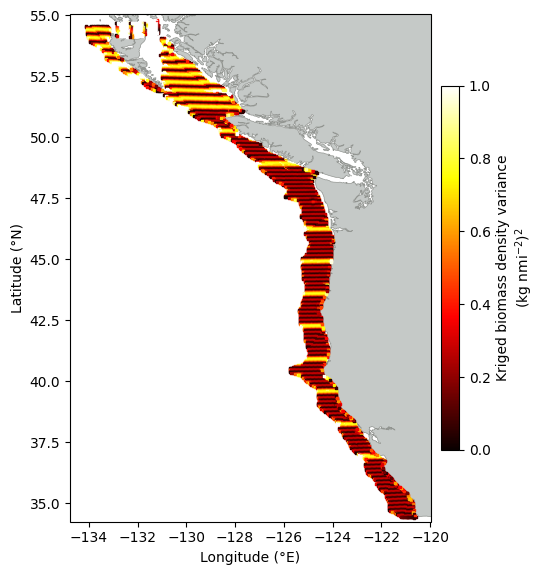

In [11]:
survey.plot(kind="mesh", 
            variable="kriged_variance", 
            plot_type="scatter")

Alternatively, these data can be interpolated to generate a pseudocolor plot via a nearest-neighbors algorithm. This can be helpful for visualizing broader spatial trends where data may be sparse or otherwise noisy:

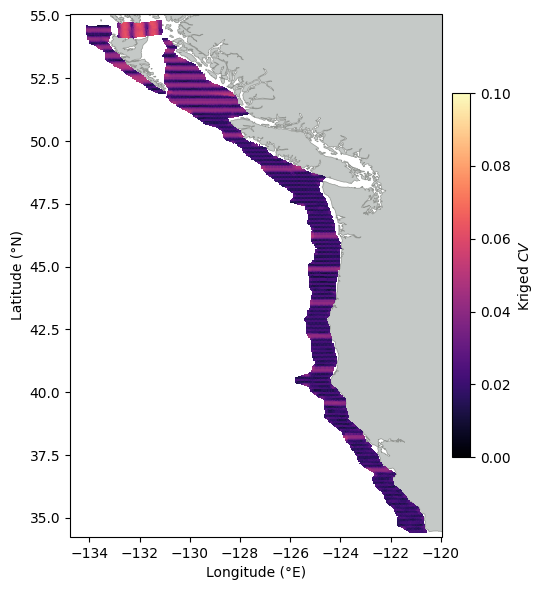

In [12]:
survey.plot(kind="mesh", 
            variable="kriged_cv", 
            plot_type="pcolormesh")